In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from pretty_confusion_matrix import pp_matrix_from_data

In [ ]:
base_dir = 'dataset'
keanu_dir = f'{base_dir}/keanu'
other_dir = f'{base_dir}/other'

In [ ]:
img_width, img_height = 300, 300
num_classes = 3
batch_size = 32

In [ ]:
splitfolders.ratio(base_dir, output='split', seed=1337, ratio=(0.70, 0.15, 0.15))

Copying files: 3000 files [00:01, 2836.75 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    'split/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    'split/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
65/65 [==============================] - 10s 148ms/step - loss: 0.6799 - accuracy: 0.7147 - val_loss: 0.2367 - val_accuracy: 0.8973
Epoch 2/50
65/65 [==============================] - 10s 148ms/step - loss: 0.2827 - accuracy: 0.8825 - val_loss: 0.1811 - val_accuracy: 0.9152
Epoch 3/50
65/65 [==============================] - 10s 146ms/step - loss: 0.2424 - accuracy: 0.8970 - val_loss: 0.1930 - val_accuracy: 0.9353
Epoch 4/50
65/65 [==============================] - 10s 146ms/step - loss: 0.2283 - accuracy: 0.9091 - val_loss: 0.1531 - val_accuracy: 0.9375
Epoch 5/50
65/65 [==============================] - 10s 147ms/step - loss: 0.1862 - accuracy: 0.9221 - val_loss: 0.1435 - val_accuracy: 0.9464
Epoch 6/50
65/65 [==============================] - 10s 146ms/step - loss: 0.1780 - accuracy: 0.9328 - val_loss: 0.1342 - val_accuracy: 0.9487
Epoch 7/50
65/65 [==============================] - 10s 147ms/step - loss: 0.1819 - accuracy: 0.9279 - val_loss: 0.1309 - val_accuracy: 0.9621

In [ ]:
model.save('wma_s20354.h5')

In [ ]:
model = load_model('wma_s20354.h5')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 128)     

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    'split/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 450 images belonging to 3 classes.


In [ ]:
loss, accuracy = model.evaluate(test_generator)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

15/15 [==============================] - 1s 52ms/step - loss: 0.0847 - accuracy: 0.9800
Test loss: 0.08465741574764252
Test accuracy: 0.9800000190734863


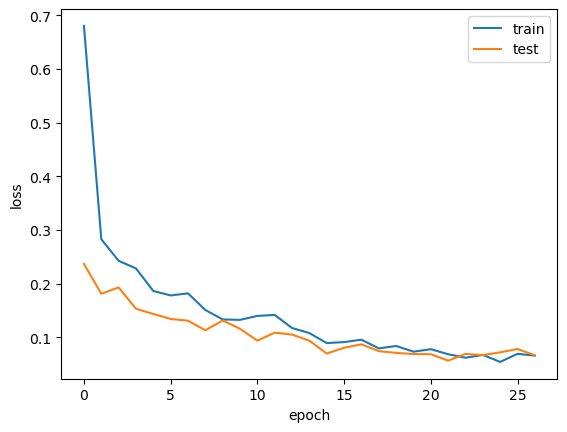

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

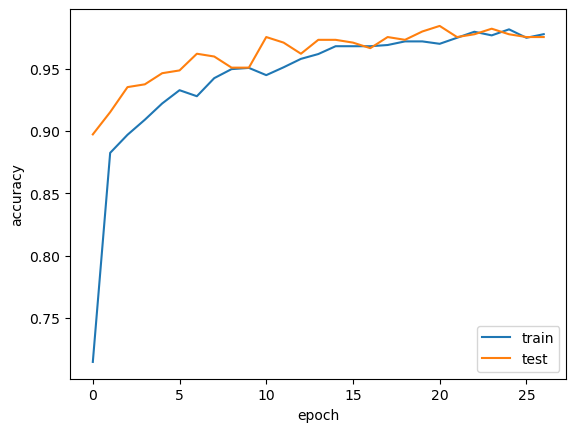

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

print(f'Accuracy: {accuracy_score(true_labels, predicted_labels)}')

15/15 [==============================] - 1s 48ms/step
Accuracy: 0.98


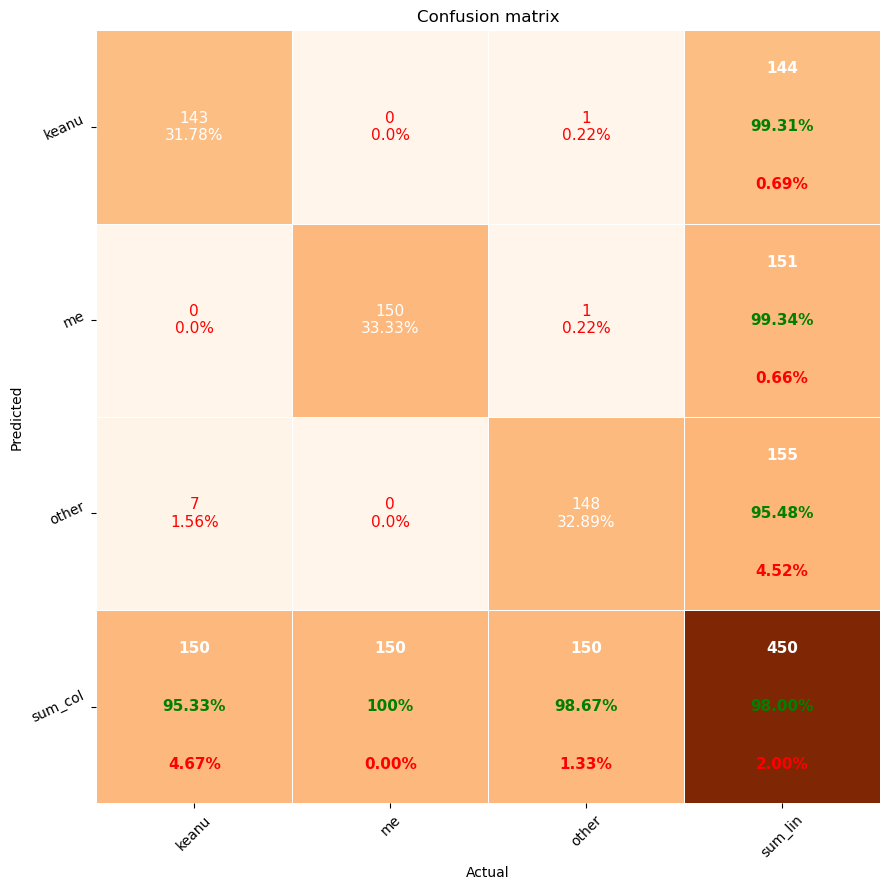

In [ ]:
pp_matrix_from_data(true_labels, predicted_labels, columns=test_generator.class_indices.keys())

In [ ]:
labels_dict = dict((value, key) for key, value in test_generator.class_indices.items())

In [ ]:
def predict(face):
    normalised = face / 255.0
    normalised = np.expand_dims(normalised, axis=-1)
    normalised = np.expand_dims(normalised, axis=0)

    probabilities = np.squeeze(model.predict(normalised, verbose=0))

    predicted_index = np.argmax(probabilities)
    predicted_label = labels_dict[predicted_index]
    predicted_probability = probabilities[predicted_index]

    return predicted_label, predicted_probability